# Week 4 Homework

In [1]:
!pip install numpyro

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

from patsy import dmatrices

import jax.numpy as jnp
from jax import random, vmap, lax

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro import sample, deterministic
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive

from plotnine import *

import arviz as az

numpyro.set_host_device_count(4)
key = random.PRNGKey(0)

## Problem 1

Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by the king with surveying the birb population. They have each found the following proportions of 5 important birb species:

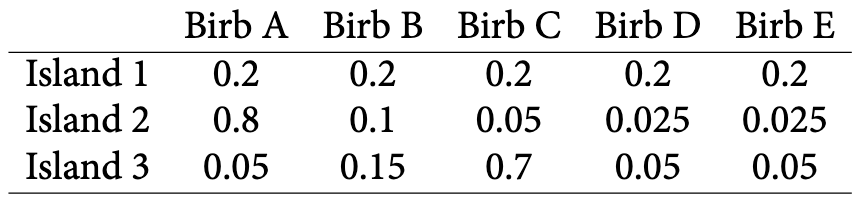

Notice that each row sums to 1, all the birbs. This problem has two parts. It is not computationally complicated. But it is conceptually tricky. First, compute the entropy of each island’s birb distribution. Interpret these entropy values. Second, use each island’s birb distribution to predict the other two. This means to compute the K-L Divergence of each island from the others, treating each island as if it were a statistical model of the other islands. You should end up with 6 different K-L Divergence values. Which island predicts the others best? Why?

In [3]:
birbs = jnp.array([[0.2, 0.2, 0.2, 0.2, 0.2],
                   [0.8, 0.1, 0.05, 0.025, 0.025],
                   [0.05, 0.15, 0.7, 0.05, 0.05]])

In [4]:
print(-(birbs * jnp.log(birbs)).sum(axis=1))

[1.609438   0.7430039  0.98360026]


We can see that Island 1 has the highest entropy, meaning its birb distribution is the least surprising of the three. Island 2 has slightly lower entropy than Island 3.

In [5]:
p = birbs[0,:]
q = birbs[1,:]

def KLD(p, q):
  return (p * (jnp.log(p) - jnp.log(q))).sum()

# Make matrix of all divergences
# In row i, we use each island to predict Island i
KLD_m = jnp.array([[KLD(birbs[i,:], birbs[j,:]) for j in range(3)] for i in range(3)])
print(KLD_m)

[[0.         0.97040606 0.63876045]
 [0.866434   0.         2.0109143 ]
 [0.6258376  1.8388451  0.        ]]


If we look across the rows of this matrix, we see how well each island is predicted by the others. Unsurprisingly, every island is predicted perfectly by itself. We can see that Island 1 is the best predictor of both Island 2 and Island 3. Because Island 1 has such high entropy, very few distributions "surprise" it.

## Problem 2

Recall the marriage, age, and happiness collider bias example from Chapter 6. Run models `m6.9` and `m6.10` again. Compare these two models using WAIC (or LOO, they will produce identical results). Which model is expected to make better predictions? Which model provides the correct causal inference about the influence of age on happiness? Can you explain why the answers to these two questions disagree?

In [6]:
 # https://fehiepsi.github.io/rethinking-numpyro/06-the-haunted-dag-and-the-causal-terror.html

def sim_happiness(seed=1977, N_years=1000, max_age=65, N_births=20, aom=18):
    # age existing individuals & newborns
    A = jnp.repeat(jnp.arange(1, N_years + 1), N_births)
    # sim happiness trait - never changes
    H = jnp.repeat(jnp.linspace(-2, 2, N_births)[None, :], N_years, 0).reshape(-1)
    # not yet married
    M = jnp.zeros(N_years * N_births, dtype=jnp.int32)

    def update_M(i, M):
        # for each person over 17, chance get married
        married = dist.Bernoulli(logits=(H - 4)).sample(random.PRNGKey(seed + i))
        return jnp.where((A >= i) & (M == 0), married, M)

    M = lax.fori_loop(aom, max_age + 1, update_M, M)
    # mortality
    deaths = A > max_age
    A = A[~deaths]
    H = H[~deaths]
    M = M[~deaths]

    d = pd.DataFrame({"age": A, "married": M, "happiness": H})
    return d


d = sim_happiness(seed=1977, N_years=1000)
marriage = d[d.age > 17].copy()
marriage["A"] = (marriage.age - 18) / (65 - 18)

In [7]:
def m6_9(m_i, A, y = None):
  sigma = sample('sigma', dist.Exponential(1))
  bA = sample('bA', dist.Normal(0, 2))
  a = sample('a', dist.Normal(0, 1), sample_shape=(2,))
  mu = deterministic('mu', a[m_i] + bA * A)

  obs = sample('obs', dist.Normal(mu, sigma), obs = y)

In [8]:
key, key_ = random.split(key)

# Run NUTS.
kernel = NUTS(m6_9)
num_samples = 2000
mcmc_m69 = MCMC(kernel, num_warmup=1000, num_chains=4,
            num_samples=num_samples, progress_bar=True)
mcmc_m69.run(key_,
         m_i = jnp.array(marriage['married']),
         A = jnp.array(marriage['A']),
         y = jnp.array(marriage['happiness'])
         )
mcmc_m69.print_summary()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.20      0.07     -0.19     -0.30     -0.08   2796.32      1.00
      a[1]      1.23      0.09      1.23      1.08      1.37   2707.54      1.00
        bA     -0.69      0.12     -0.69     -0.88     -0.50   2551.05      1.00
     sigma      1.02      0.02      1.02      0.98      1.06   4970.97      1.00

Number of divergences: 0


In [9]:
def m6_10(A, y = None):
  sigma = sample('sigma', dist.Exponential(1))
  bA = sample('bA', dist.Normal(0, 2))
  a = sample('a', dist.Normal(0, 1))
  mu = deterministic('mu', a + bA * A)

  obs = sample('obs', dist.Normal(mu, sigma), obs = y)

In [10]:
key, key_ = random.split(key)

# Run NUTS.
kernel = NUTS(m6_10)
num_samples = 2000
mcmc_m610 = MCMC(kernel, num_warmup=1000, num_chains=4,
            num_samples=num_samples, progress_bar=True)
mcmc_m610.run(key_,
         A = jnp.array(marriage['A']),
         y = jnp.array(marriage['happiness'])
         )
mcmc_m610.print_summary()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.08      0.00     -0.13      0.12   3261.10      1.00
        bA     -0.00      0.13     -0.00     -0.22      0.21   3218.16      1.00
     sigma      1.22      0.03      1.22      1.17      1.26   4701.12      1.00

Number of divergences: 0


In [11]:
# Conver to az InferenceData
az_m69 = az.from_numpyro(mcmc_m69)
az_m610 = az.from_numpyro(mcmc_m610)

In [12]:
loo_res = az.compare({'m6_9': az_m69, 'm6_10': az_m610}, ic='loo')
loo_res

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m6_9,0,-1381.965715,3.557261,0.000000,0.990874,17.618803,0.000000,False,log
m6_10,1,-1550.999784,2.386186,169.034069,0.009126,13.821889,16.647452,False,log


Model `m6.9` has a significantly higher ELPD, than `m6.10`, suggesting that its OOS predictive performance is better. That is not surprising because it accounts for the real direct association between marriage and happiness. However, we know for a fact that `m6.10` is more causally valid. ELPD only cares about prediction and has no sense of causal validity.

## Problem 3

Reconsider the urban fox analysis from last week’s homework. Use WAIC or LOO based model comparison on five different models, each using weight as the outcome, and containing these sets of predictor variables:
	
1. `avgfood + groupsize + area`
1. `avgfood + groupsize`
1. `groupsize + area`
1. `avgfood`
1. `area`

Can you explain the relative differences in WAIC scores, using the fox DAG from last week’s homework? Be sure to pay attention to the standard error of the score differences (dSE).

In [13]:
def mod(X, y = None):
  B = numpyro.sample('B', dist.Normal(0, 5), sample_shape = (X.shape[1],))
  sigma = numpyro.sample('sigma', dist.Exponential(1))

  mu = numpyro.deterministic('mu', X.dot(B))
  obs = numpyro.sample('obs', dist.Normal(mu, sigma), obs = y)

In [14]:
foxes = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv', delimiter=';')
for v in ['weight', 'area', 'groupsize', 'avgfood']:
  foxes[v] = (foxes[v] - foxes[v].mean())/foxes[v].std()
print(foxes.shape)
foxes.head()

(116, 5)


,group,avgfood,groupsize,area,weight
0,1,-1.924829,-1.524089,-2.239596,0.414135
1,1,-1.924829,-1.524089,-2.239596,-1.427046
2,2,-1.118035,-1.524089,-1.205508,0.675954
3,2,-1.118035,-1.524089,-1.205508,1.300942
4,3,-1.319734,-1.524089,-1.130106,1.115135


In [15]:
dep_var_list = ['avgfood + groupsize + area',
                'avgfood + groupsize',
                'groupsize + area',
                'avgfood',
                'area']

In [16]:
mcmc_dict = {}
for dep_vars in dep_var_list:
  fm = 'weight ~ {}'.format(dep_vars)
  print('Fitting {}'.format(fm))
  # NB: y will be a column vector!
  y, X = dmatrices(fm, foxes)

  key, key_ = random.split(key)

  # Run NUTS.
  kernel = NUTS(mod)
  num_samples = 1000
  mcmc = MCMC(kernel, num_warmup=2000, num_chains=4,
              num_samples=num_samples, progress_bar=False)
  mcmc.run(key_,
          X = jnp.array(X),
          y = jnp.array(y.flatten())
          )
  mcmc_dict[dep_vars] = mcmc

Fitting weight ~ avgfood + groupsize + area
Fitting weight ~ avgfood + groupsize
Fitting weight ~ groupsize + area
Fitting weight ~ avgfood
Fitting weight ~ area


In [17]:
waic_res = az.compare(mcmc_dict, ic='loo')
waic_res

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
avgfood + groupsize + area,0,-161.684225,5.021534,0.000000,2.402712e-16,7.993503,0.000000,False,log
avgfood + groupsize,1,-161.899402,3.934476,0.215177,5.179891e-01,8.006695,1.832488,False,log
groupsize + area,2,-162.017599,3.777589,0.333374,4.560492e-01,7.649686,1.971869,False,log
avgfood,3,-166.902750,2.529117,5.218525,2.625183e-16,6.649174,4.072029,False,log
area,4,-167.030855,2.737040,5.346630,2.596174e-02,6.619850,4.098808,False,log


Models 1, 2, and 3 are all better than Models 4 and 5. Within the two groups (1,2,3 and 4,5), no model seems to be significantly better than another (`dse` close to `d_loo`). As long as we condition on `groupsize`, `area` and `avgfood` follow the same path to `weight`, so they explain the same variation. Including one is just as good as including the other. When we remove `groupsize`, every path from `area` to `weight` includes `avgfood`, so they still provide the same inference.

In [18]:
[x.print_summary() for x in mcmc_dict.values()]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      B[0]     -0.00      0.09     -0.00     -0.15      0.14   3882.56      1.00
      B[1]      0.41      0.24      0.41      0.01      0.80   2318.72      1.00
      B[2]     -0.79      0.20     -0.79     -1.12     -0.46   2761.69      1.00
      B[3]      0.30      0.19      0.30     -0.03      0.61   2904.51      1.00
     sigma      0.96      0.07      0.95      0.85      1.06   3291.78      1.00

Number of divergences: 0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      B[0]      0.00      0.09      0.00     -0.14      0.16   2845.09      1.00
      B[1]      0.64      0.20      0.64      0.33      0.99   2201.60      1.00
      B[2]     -0.74      0.20     -0.74     -1.06     -0.41   2347.75      1.00
     sigma      0.96      0.06      0.96      0.85      1.06   2896.24      1.00

Number of divergences: 0

                mean       std    median      5.0%    

[None, None, None, None, None]